In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from google.colab import files

## Загрузка и обзор данных
Загружаем очищенный датасет и проверяем его на наличие пропущенных значений.
Также выводим общую информацию по таблице.

In [125]:
df = pd.read_csv("cleaned_df.csv")

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1226 non-null   object
 1   Age                        1226 non-null   int64 
 2   Gender                     1226 non-null   object
 3   Country                    1226 non-null   object
 4   state                      1226 non-null   object
 5   self_employed              1226 non-null   object
 6   family_history             1226 non-null   object
 7   treatment                  1226 non-null   object
 8   work_interfere             1226 non-null   object
 9   no_employees               1226 non-null   object
 10  remote_work                1226 non-null   object
 11  tech_company               1226 non-null   object
 12  benefits                   1226 non-null   object
 13  care_options               1226 non-null   object
 14  wellness

Мы имеем 1226 записей, каждая запись имеет 27 колонок с признаками

In [127]:
df.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0


Мы обработали нулевые значения в TechSurveyPreprocessing.ipynb, поэтому тут их нет


## Анализ распределения возрастов
Исследуем распределение значений возраста с помощью гистограммы и коробчатой диаграммы.

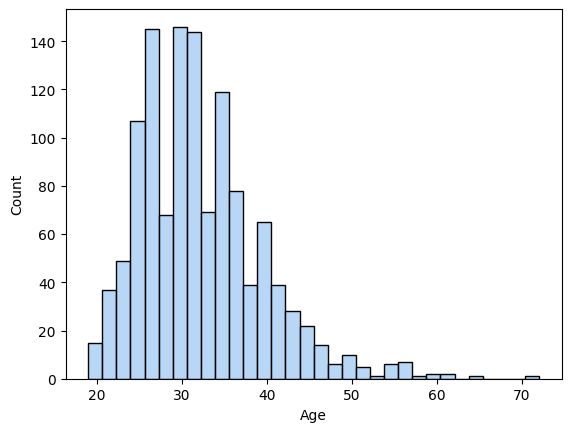

In [128]:
colors = sns.color_palette('pastel')
sns.histplot(df['Age'], color=colors[0])
plt.show()

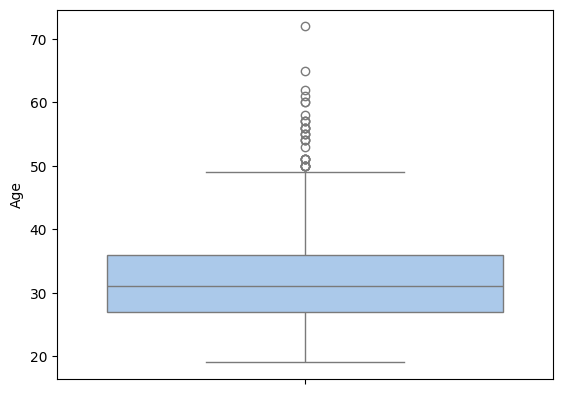

In [129]:
sns.boxplot(df['Age'], color=colors[0])
plt.show()

По графику видно, что медианное значение возраста чуть больше 30 лет.

## Группировка возрастов
Создаем возрастные группы и исследуем, как распределяется лечение по этим группам.

In [130]:
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66 and older']

In [131]:
df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
age_group_counts = df['Age_group'].value_counts()
print(age_group_counts)


Age_group
26-35           698
36-45           313
18-25           147
46-55            51
56-65            15
66 and older      2
Name: count, dtype: int64


Так как у нас всего 2 записи о людях, чей возраст превышает 65 лет, то мы не можем делать статистически значимые выводы об этой группе. По этой причине мы не будет анализировать эту возрастную группу.

In [132]:
df_filtered = df[df['Age_group'] != '66 and older']
df_filtered['Age_group'] = df_filtered['Age_group'].cat.remove_unused_categories()

treatment_by_age_group = df_filtered.groupby('Age_group')['treatment'].value_counts(normalize=True).unstack()
treatment_by_age_group_melted = treatment_by_age_group.reset_index().melt(id_vars='Age_group')

<ipython-input-132-f7bc8d17b894>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Age_group'] = df_filtered['Age_group'].cat.remove_unused_categories()
<ipython-input-132-f7bc8d17b894>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_by_age_group = df_filtered.groupby('Age_group')['treatment'].value_counts(normalize=True).unstack()


<ipython-input-133-9c2652e02487>:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=treatment_by_age_group_melted, x='Age_group', y='value', hue='treatment',


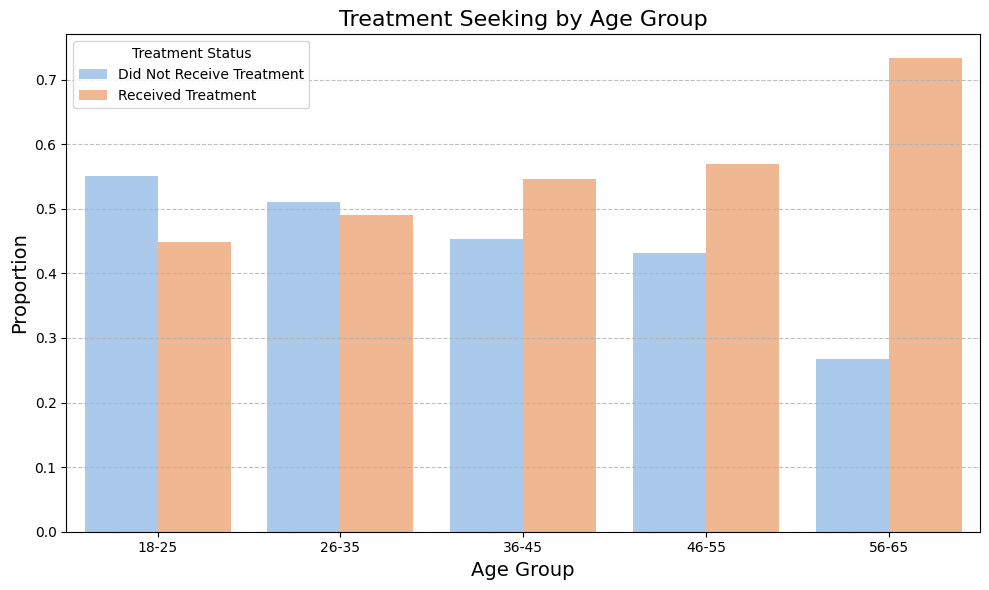

In [133]:
plt.figure(figsize=(10, 6))

sns.barplot(data=treatment_by_age_group_melted, x='Age_group', y='value', hue='treatment',
            palette=colors, hue_order=['No', 'Yes'])

plt.title('Treatment Seeking by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=0)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Did Not Receive Treatment', 'Received Treatment'], title='Treatment Status')

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)
plt.tight_layout()
plt.show()


Взрослые люди в возрасте 36-65 лет чаще других возрастных групп обращаются за лечением психический заболеваний. Также мы видим, что чем старше группа респондентов, тем больше доля тех, кто обращался за леченем.


## Гендерное распределение
Изучаем распределение значений пола в датасете.

In [134]:
df['Standardized_gender'].value_counts().index

Index(['male', 'female', 'other'], dtype='object', name='Standardized_gender')

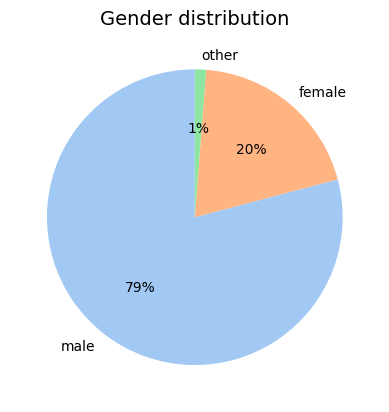

In [135]:
colors = sns.color_palette('pastel')

values = df['Standardized_gender'].value_counts().values
labels = df['Standardized_gender'].value_counts().index

plt.pie(values,
        labels=labels,
        autopct='%1.0f%%',
        startangle=90,
        colors=colors)

plt.title('Gender distribution', fontsize=14)
plt.show()


Как мы видим, в нашем датасете преобладают записи о мужчинах, их процент от общего числа составляет 79%. Женщин 20%. Оставшийся процент приходится на людей, которые не относят себя ни к мужчинам, ни к женщинам.

## Процент записей по странам
Анализируем, сколько записей в датасете приходится на разные страны. Рассматриваем ТОП-10 стран по количеству записей.


In [136]:
top_countries = df['Country'].value_counts().head(10)
top_countries

,count
Country,
United States,732
United Kingdom,181
Canada,68
Germany,45
Ireland,27
Netherlands,26
Australia,21
France,13
India,10


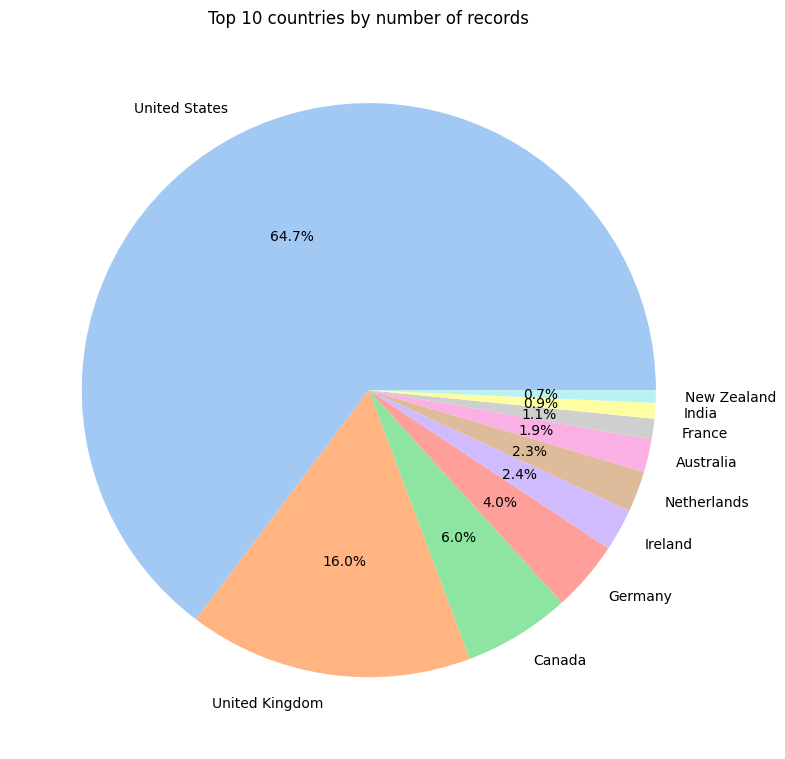

In [137]:
plt.figure(figsize=(8,8))
plt.pie(top_countries, labels=top_countries.index, colors=colors, autopct='%1.1f%%')
plt.title('Top 10 countries by number of records')
plt.tight_layout()
plt.show()

Большинство записей приходится на людей из Соединенных Штатов Америки и из Великобритании. Большинство стран из топ-10 составляют старны западного мира, что может указывать о более высоком уровне сбора данных, доступности услуг или культурных факторов, способствующих обращению за помощью в этих странах.

## Процент лечения в ТОП-10 странах
Исследуем процент людей, обращающихся за лечением в зависимости от страны.

In [138]:
top_countries_indexes = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_countries_indexes)]
treatment_percent = filtered_df.groupby("Country")['treatment'].value_counts(normalize=True).unstack()['Yes']*100

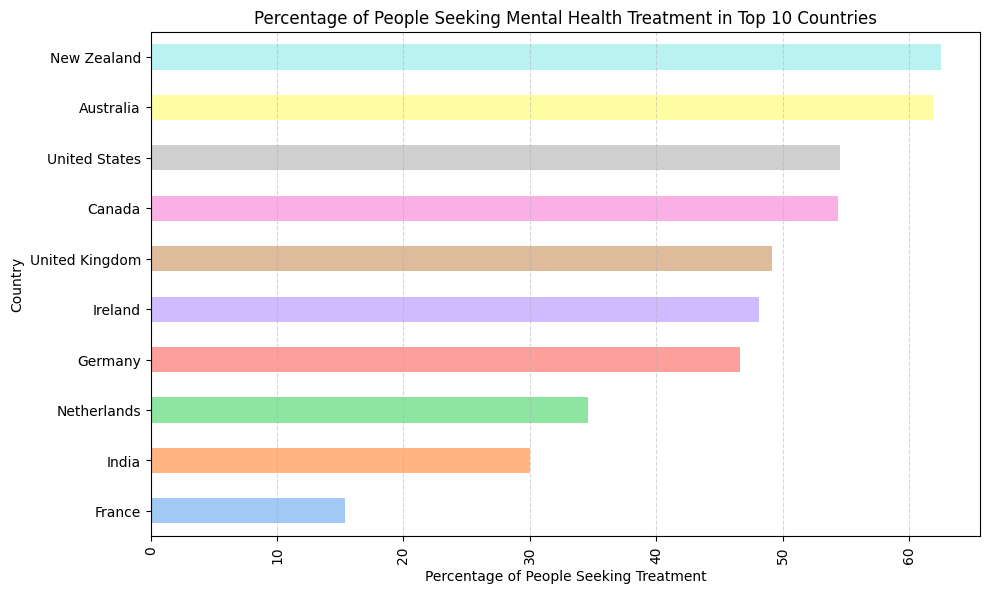

In [139]:
plt.figure(figsize=(10,6))
treatment_percent.sort_values().plot(kind='barh', color=colors)
plt.xlabel('Percentage of People Seeking Treatment')
plt.title('Percentage of People Seeking Mental Health Treatment in Top 10 Countries')
plt.tight_layout()
plt.grid(axis='x', alpha=0.5, linestyle ='--')
plt.xticks(rotation=90)
plt.show()

Анализ показывает, что проценты в Новой Зеландии и Австралии (более 60% для каждой) являются самыми высокими среди всех стран из топ-10 по количеству записей. Однако стоит заметить, что у нас довольно мало записей по Новой Зеландии (8) и Австралии (21), что может исказить анализ. Также лидерами по доле обращений являются США, Канада и Великобритания, что может указывать на культурные, социальные и системные особенности этих стран.

## Анализ зависимости обращения за лечением от различных факторов
Исследуем, как такие факторы как тип работы, семейная история, пол и другие влияют на обращение за лечением.

In [140]:
treatment_by_country = df.groupby('Country')['treatment'].value_counts(normalize=True).unstack()
data=treatment_by_country_melted = treatment_by_country.reset_index().melt(id_vars='Country')

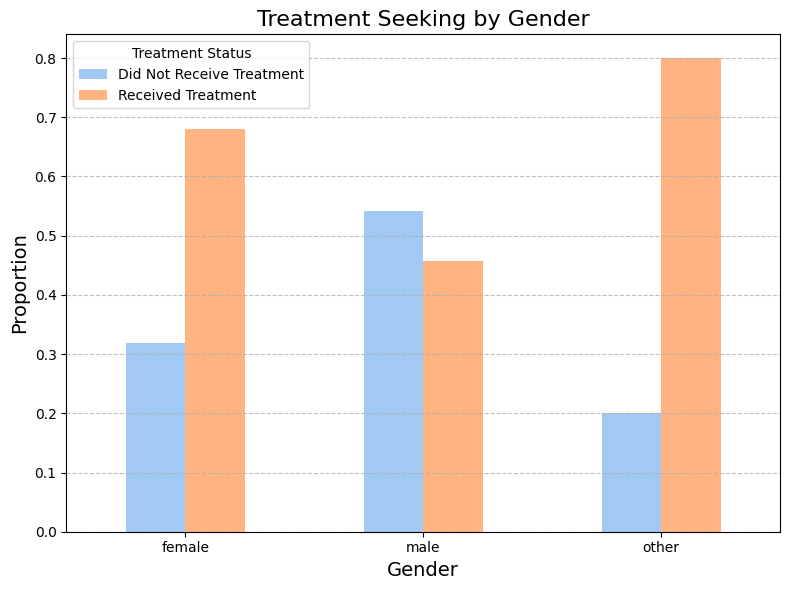

In [141]:
treatment_by_gender = df.groupby('Standardized_gender')['treatment'].value_counts(normalize=True).unstack().fillna(0)
treatment_by_gender.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(8, 6))

plt.title('Treatment Seeking by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.legend(title='Treatment Status', labels=treatment_labels)
plt.tight_layout()
plt.show()

По графику видно, что наименьшая доля обращений за помощью наблюдается у мужчин. У женщин эта доля значительно превышает 50%, в то время как среди людей, идентифицирующих себя иначе, чем мужчины или женщины, доля обращающихся за помощью составляет подавляющее большинство. Это может свидетельствует о значительном различии отношения к своему психическому здоровью в зависимости от пола, но возможны  также и другие причины.


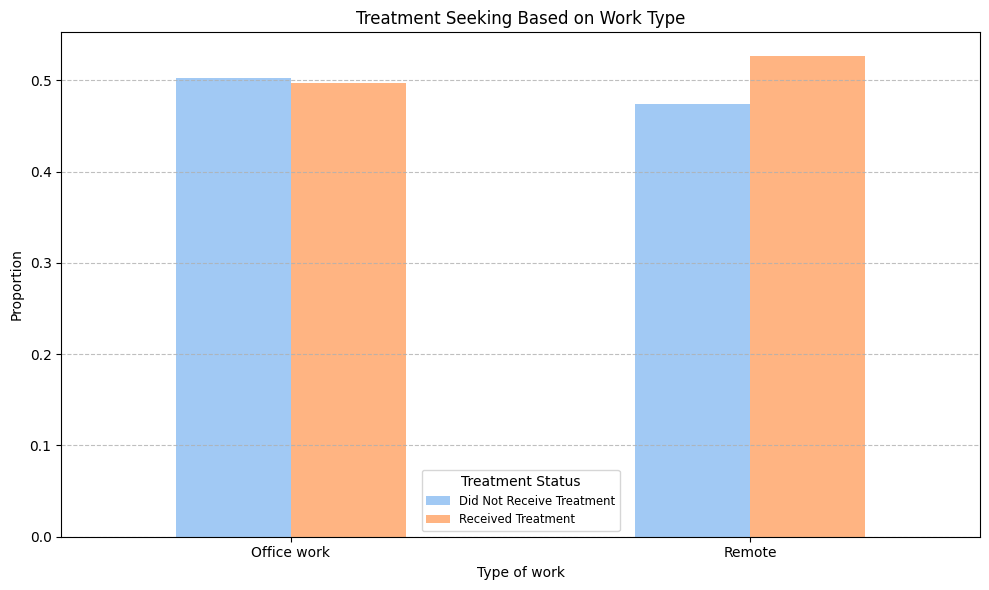

In [142]:
treatment_by_type_work = df.groupby('remote_work')['treatment'].value_counts(normalize=True).unstack()
treatment_by_type_work.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(10, 6))

plt.title('Treatment Seeking Based on Work Type')
plt.xlabel('Type of work')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

plt.gca().set_xticklabels(['Office work', 'Remote'])

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.legend(title='Treatment Status', labels=treatment_labels, fontsize='small')
plt.tight_layout()
plt.show()

Люди, которые работают удаленно, обращаются за лечением чаще. Это может свидетельствовать в том числе о том, что таким людям легче найти время для обращения или о том, что такие люди больше подвержены психическим заболеваниям из-за изоляции и стресса, связанных с удаленной работой.

<ipython-input-143-8d930585b0de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=family_history_count.index, y=family_history_count.values, palette='pastel')


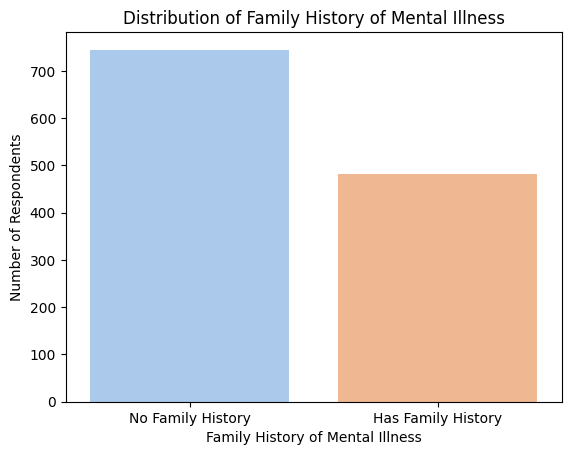

In [143]:
family_history_count = df['family_history'].replace({'Yes': 'Has Family History', 'No': 'No Family History'}).value_counts()

sns.barplot(x=family_history_count.index, y=family_history_count.values, palette='pastel')
plt.title('Distribution of Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Number of Respondents')
plt.show()

Большинство опрошенных не имеют семейной истории, связанной с психическими заболеваниями.

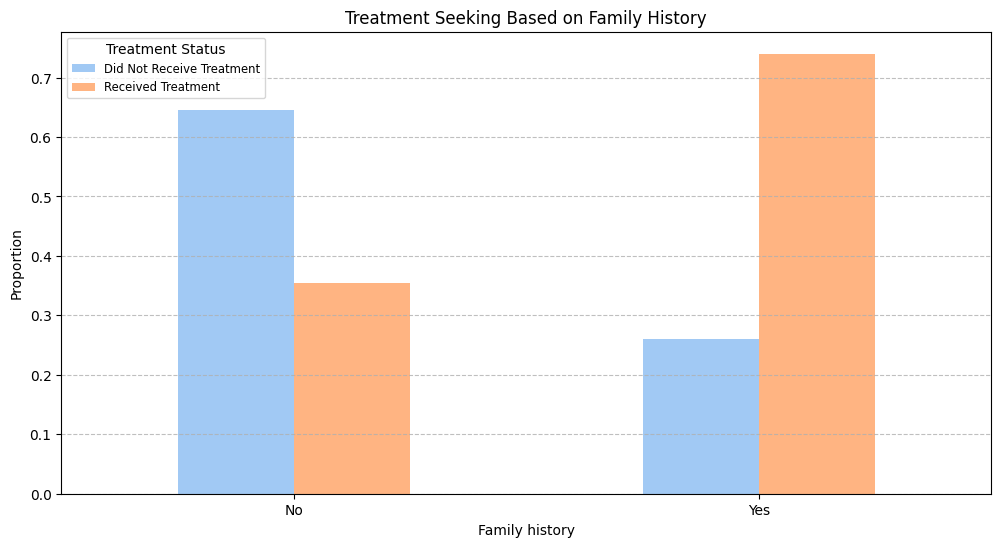

In [144]:
treatment_by_family_hist = df.groupby('family_history')['treatment'].value_counts(normalize=True).unstack()
treatment_by_family_hist.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(12, 6))

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.title('Treatment Seeking Based on Family History')
plt.xlabel('Family history')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Treatment Status', labels=treatment_labels, fontsize='small')
plt.show()

Мы видим, что наличие семейной истории психических заболеваний сильно влияет на вероятность обращения за лечением. Это может говорить о том, что если в семье уже есть люди с психическими заболеваниями, то остальные члены семьи относятся к своему психическому здоровью внимательнее.

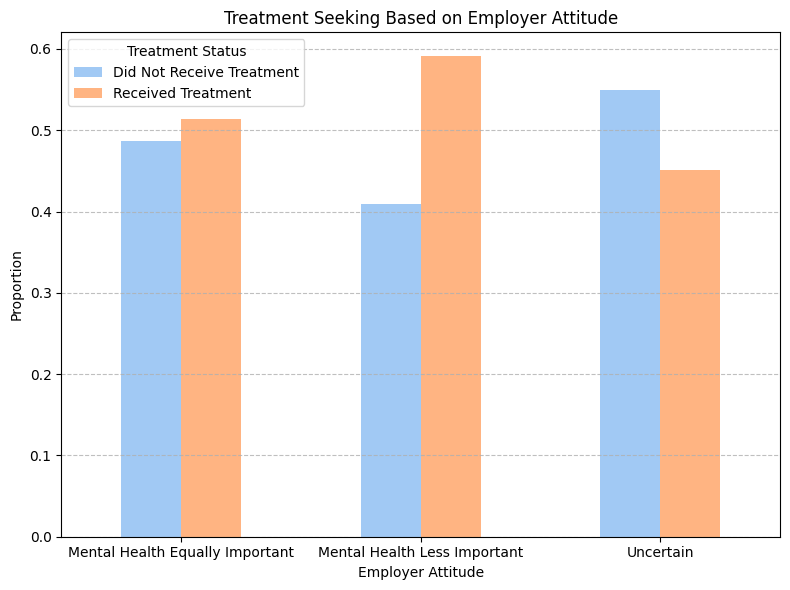

In [145]:
df['mental_vs_physical'] = df['mental_vs_physical'].replace({
    'No': 'Mental Health Less Important',
    'Yes': 'Mental Health Equally Important',
    'Don\'t know': 'Uncertain'
})

treatment_by_employer_attitude = df.groupby('mental_vs_physical')['treatment'].value_counts(normalize=True).unstack()
treatment_by_employer_attitude.plot(kind='bar', stacked=False, color=sns.color_palette('pastel'), figsize=(8, 6))

plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)

plt.title('Treatment Seeking Based on Employer Attitude')
plt.xlabel('Employer Attitude')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Treatment Status', labels=treatment_labels)
plt.tight_layout()
plt.show()


По графику видно, что люди, которые не знают относятся ли работодатель также внимательно к психическому здоровью, как к физическому, реже обращаются за лечением. Это может объясняться тем, что такие люди просто не заинтересованы в лечении. Среди тех, чей работодатель ответсвенно относится к психическому здоровью доля людей, обратившихся за лечением меньше, чем у тех работодателей, которые пренебрегают им. Таким образом, забота о психическом здоровье со стороны работодателя может снижать уровень обращений среди обеспокоенных работников.

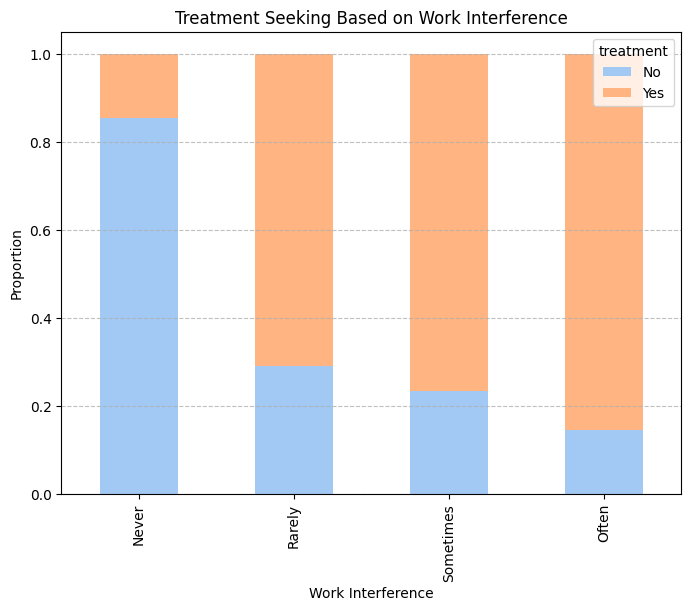

In [146]:
order = ['Never', 'Rarely', 'Sometimes', 'Often']

filtered_df = df.loc[df['work_interfere'] != 'No data'].copy()

filtered_df.loc[:, 'work_interfere'] = pd.Categorical(filtered_df['work_interfere'], categories=order, ordered=True)

work_interfere_treatment = filtered_df.groupby('work_interfere')['treatment'].value_counts(normalize=True).unstack().fillna(0)

for category in order:
    if category not in work_interfere_treatment.index:
        work_interfere_treatment.loc[category] = [0] * len(work_interfere_treatment.columns)

work_interfere_treatment = work_interfere_treatment.reindex(order)

work_interfere_treatment.plot(kind='bar', stacked=True, color=sns.color_palette('pastel'), figsize=(8, 6))
plt.title('Treatment Seeking Based on Work Interference')
plt.xlabel('Work Interference')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.8)
plt.show()

График предсказуемо показыват, что чем больше влияение психического состояния на работу, тем большая доля респондентов обращается за лечением.


**Анализ показывает, что такие факторы как наличие семейной истории заболеваний, пол, возраст и влияние психического состояния на работу набиолее сильно влияют на вероятность обращения за лечением.**
1. **Семейная история**: если у респондента имеется семейная история психических заболеваний, то это значительно увеличивает вероятность обращения за лечением.
2. **Пол**: женщины чаще мужчин обращаются за лечением. Среди людей, чей пол ни мужской, ни женский, доля обращений составляет вплоть до 80%
3. **Возраст**: чем старше респондент, тем с большей вероятностью он обращается за лечением.
4. **Влияние на работу**: чем чаще психические заболевания влияют на работу, тем с большей вероятностью респондент обратится за лечением.

## Выбор значимых признаков
Используем критерий хи-квадрат для выбора значимых признаков, влияющих на обращение за лечением.

In [147]:
selected_features = ['Age', 'Standardized_gender', 'self_employed', 'family_history', 'work_interfere',
                     'no_employees', 'remote_work', 'tech_company', 'benefits',
                     'care_options', 'wellness_program', 'seek_help', 'anonymity',
                     'leave', 'mental_health_consequence', 'phys_health_consequence',
                     'coworkers', 'supervisor', 'mental_health_interview',
                     'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

df_selected = df[selected_features + ['treatment']]

categorical_columns = ['Standardized_gender', 'self_employed', 'family_history', 'work_interfere',
                       'no_employees', 'remote_work', 'tech_company', 'benefits',
                       'care_options', 'wellness_program', 'seek_help', 'anonymity',
                       'leave', 'mental_health_consequence', 'phys_health_consequence',
                       'coworkers', 'supervisor', 'mental_health_interview',
                       'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
df_encoded = pd.get_dummies(df_selected, columns=categorical_columns)

scaler = MinMaxScaler()

# Нормализуем столбец Age
df_encoded['Age'] = scaler.fit_transform(df_encoded[['Age']])

In [148]:
# Преобразуем 'treatment' из строковых значений в бинарные (0 и 1)
df_encoded['treatment'] = df_encoded['treatment'].map({'Yes': 1, 'No': 0})


In [152]:
X = df_encoded.drop('treatment', axis=1)
y= df_encoded['treatment']

# Применяем критерий хи-квадрат
chi2_values, p_values = chi2(X, y)

# Создаем DataFrame с результатами
chi2_results = pd.DataFrame({'Feature': X.columns, 'Chi2': chi2_values, 'p-value': p_values})

# Сортируем по p-value
chi2_results = chi2_results.sort_values(by='p-value')

# Выводим первые 10 признаков с наименьшими p-value
top_10_significant_features = chi2_results.head(10)
print(top_10_significant_features)



                       Feature        Chi2       p-value
9       work_interfere_No data  250.067968  2.509701e-56
12    work_interfere_Sometimes  124.303807  7.228411e-29
8         work_interfere_Never  105.913101  7.704060e-25
7           family_history_Yes  105.738447  8.413897e-25
6            family_history_No   68.268715  1.426665e-16
10        work_interfere_Often   66.490033  3.516673e-16
28            care_options_Yes   59.171115  1.445400e-14
25                benefits_Yes   32.905857  9.673140e-09
1   Standardized_gender_female   29.454957  5.723148e-08
23         benefits_Don't know   28.657629  8.637303e-08


Результаты критерия хи-квадрата показывают, что признаки work_interfere и family_history имеют наименьшее значение p, что указывает на их значительное влияние на обращение за лечением.

In [150]:
# Фильтруем признаки с p-value меньше 0.05
significant_features = chi2_results[chi2_results['p-value'] < 0.05]

significant_feature_names = significant_features['Feature'].tolist()

# Создаем новый DataFrame с значимыми признаками и целевой переменной
df_significant = df_encoded[significant_feature_names + ['treatment']]


df_significant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 32 columns):
 #   Column                                           Non-Null Count  Dtype
---  ------                                           --------------  -----
 0   work_interfere_No data                           1226 non-null   bool 
 1   work_interfere_Sometimes                         1226 non-null   bool 
 2   work_interfere_Never                             1226 non-null   bool 
 3   family_history_Yes                               1226 non-null   bool 
 4   family_history_No                                1226 non-null   bool 
 5   work_interfere_Often                             1226 non-null   bool 
 6   care_options_Yes                                 1226 non-null   bool 
 7   benefits_Yes                                     1226 non-null   bool 
 8   Standardized_gender_female                       1226 non-null   bool 
 9   benefits_Don't know                              122

Значимые признаки мы сохраняем в отдельный файл, с его помощью будем обучать модели машинного обучения. Это поможет нам сократить время обучения, предсказания, а также повысить точность.

In [151]:
df_significant.to_csv('df_significant.csv', index=False)
files.download('df_significant.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>